In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

Global congiguration

In [4]:
TEST_SIZE = 0.2 
RANDOM_SEED = 42 
MODEL_FILENAME = 'genre_on_title.pkl' 

Load data

In [6]:
df = pd.read_csv("./data/training_data.csv")
df.dropna(subset=['Title', 'Genre'], inplace=True) # drops rows with missing values
X = df['Title'].astype(str) # feature
y = df['Genre'] # target label
print(f"Total samples: {len(X)}")

Total samples: 18087


Split into training and testing sets 

In [8]:
X_train, X_test, y_train, y_test = train_test_split( # shuffles and splits the data
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y # keeps same proportion of genre in training and testing sets
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples : {len(X_test)}")

Training samples: 14469
Testing samples : 3618


Pipeline: TF-IDF + linear SVM

In [10]:
text_clf_svc = Pipeline([ 
    ('tfidf', TfidfVectorizer( # first applies a transformer 
        ngram_range=(1, 2), 
        max_df=0.7, # ignores words appearing in more than 70% of the corpus
        stop_words='english'
    )),
    ('clf', LinearSVC( # then applies a classifier 
        C=1.0,
        class_weight='balanced', # adjusts for genres that are not well represented
        random_state=RANDOM_SEED
    )),
])

Traing phase

In [12]:
text_clf_svc.fit(X_train, y_train)
print("Cross-validation on training set (5 folds):")
cv_scores = cross_val_score(text_clf_svc, X_train, y_train, cv=5) # divides the model in 5 folds and tests 5 times
print(f"Fold scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

Cross-validation on training set (5 folds):
Fold scores: [0.92294402 0.92570836 0.92709053 0.93572909 0.92810232]
Mean CV accuracy: 0.9279


Testing phase

In [14]:
test_accuracy = text_clf_svc.score(X_test, y_test)
print(f"Final test accuracy: {test_accuracy:.4f}")
y_pred = text_clf_svc.predict(X_test) # predicts genre for the test set

Final test accuracy: 0.9320


Classification report 

In [16]:
print("Classification report:")
print(classification_report(y_test, y_pred, zero_division=0))

Classification report:
              precision    recall  f1-score   support

       Drama       0.95      0.89      0.92       319
       Music       0.96      0.87      0.91       178
      Poetry       0.93      0.88      0.91      1111
       Prose       0.93      0.97      0.95      2010

    accuracy                           0.93      3618
   macro avg       0.94      0.90      0.92      3618
weighted avg       0.93      0.93      0.93      3618



Normalized confusion matrix

In [18]:
labels = text_clf_svc.classes_
cm_norm = confusion_matrix( 
    y_test,
    y_pred,
    labels=labels,
    normalize='true'
)
cm_df = pd.DataFrame(cm_norm, index=labels, columns=labels) 
print("Normalized confusion matrix (rows = true labels):")
print(cm_df.round(2))

Normalized confusion matrix (rows = true labels):
        Drama  Music  Poetry  Prose
Drama    0.89   0.00    0.04   0.07
Music    0.01   0.87    0.04   0.08
Poetry   0.01   0.00    0.88   0.11
Prose    0.00   0.00    0.02   0.97


Plot the confusion matrix

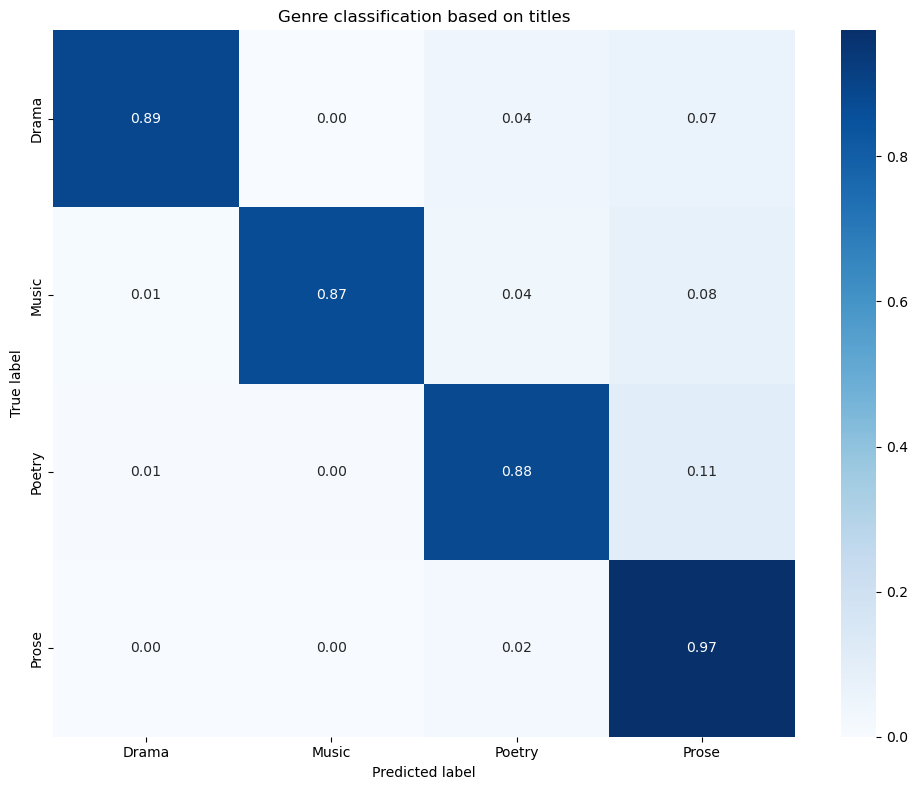

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Genre classification based on titles")
plt.tight_layout()
plt.show()

Uncertainty measures, based on SVM decisions margin

In [30]:
decision_scores = text_clf_svc.decision_function(X_test) # gets decision score for each class
sorted_scores = np.sort(decision_scores, axis=1) 
margins = sorted_scores[:, -1] - sorted_scores[:, -2] # margin uncertainty = difference between the highest and second highest score 

uncertainty_df = pd.DataFrame({
    "true_label": y_test.values,
    "predicted_label": y_pred,
    "margin": margins
}).sort_values("margin")
print("Most uncertain predictions (lowest margins):")
print(uncertainty_df.head(10))

Most uncertain predictions (lowest margins):
     true_label predicted_label    margin
3083     Poetry           Prose  0.000701
1474      Prose          Poetry  0.001581
3374     Poetry           Prose  0.003328
1281     Poetry          Poetry  0.003661
683      Poetry          Poetry  0.010532
2592      Music           Prose  0.010558
109       Prose           Prose  0.012949
3098      Prose           Prose  0.014824
3061      Prose           Prose  0.021225
1781      Music           Music  0.023010


In [ ]:
Plot the uncertainty measures

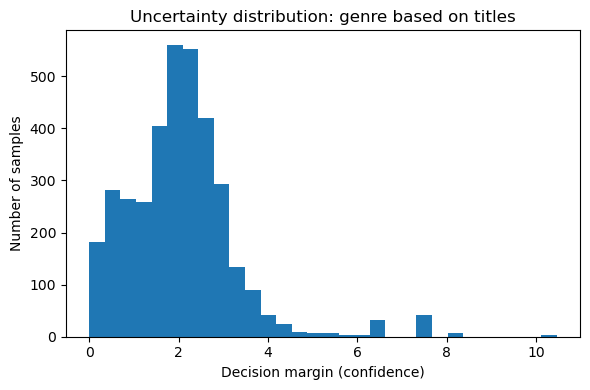

In [26]:
plt.figure(figsize=(6, 4))
plt.hist(margins, bins=30)
plt.xlabel("Decision margin (confidence)")
plt.ylabel("Number of samples")
plt.title("Uncertainty distribution: genre based on titles")
plt.tight_layout()
plt.show()

Save the model

In [32]:
joblib.dump(text_clf_svc, MODEL_FILENAME)
print(f"Model saved to: {MODEL_FILENAME}")

Model saved to: genre_on_title.pkl
